# (Advanced) Using gReLU with external pytorch models

This tutorial shows how to take a pytorch model that was not trained using gReLU, and make it compatible with gReLU's downstream functions (e.g. inference, variant effect prediction, interpretation and design).

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import os

## Load an external pytorch model

We will load the pytorch version of the Basset model from the Kipoi repository (https://kipoi.org/models/Basset/). You can also try this with any other pytorch sequence-to-function model.

Kipoi provides us the following important information about the model:

`This is the Basset model published by David Kelley converted to pytorch by Roman Kreuzhuber. It categorically predicts probabilities of accesible genomic regions in 164 cell types (ENCODE project and Roadmap Epigenomics Consortium). Data was generated using DNAse-seq. The sequence length the model uses as input is 600bp. The input of the tensor has to be (N, 4, 600, 1) for N samples, 600bp window size and 4 nucleotides. Per sample, 164 probabilities of accessible chromatin will be predicted.`

You will need to uncomment the cell below to install kipoi.

In [2]:
#!pip install kipoi

In [3]:
import kipoi
kipoi_model = kipoi.get_model('Basset', with_dataloader=False)
kipoi_model = kipoi_model.model.cpu()

Already up to date.
Using downloaded and verified file: /root/.kipoi/models/Basset/downloaded/model_files/weights/4878981d84499eb575abd0f3b45570d3


/opt/conda/lib/python3.11/site-packages/kipoi/model.py:934: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weights))


We can view the structure of this model below:

In [4]:
kipoi_model

Sequential(
  (0): Conv2d(4, 300, kernel_size=(19, 1), stride=(1, 1))
  (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1))
  (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1))
  (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (12): Lambda()
  (13): Sequential(
    (0): Lambda()
    (1): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()

## Modify the model to make it gReLU-compatible

### Step 1: Check the input and output formats

First, we need to pay attention to the shapes of the model's input and output shapes. As per Kipoi:

`The input of the tensor has to be (N, 4, 600, 1) for N samples, 600bp window size and 4 nucleotides.`

Kipoi doesn't tell us the shape of the output tensor produced by this model, so let's check by creating a random tensor of the required shape and passing it through the model.

In [5]:
random_tensor = torch.rand(2, 4, 600, 1) # N=2
random_tensor.shape

torch.Size([2, 4, 600, 1])

In [6]:
output_shape = kipoi_model(random_tensor).shape
print(output_shape)

torch.Size([2, 164])


### Step 2: Define adapter layer(s) if necessary

We see that this model expects inputs of shape `(N, 4, input_len, 1)` and produces outputs of shape `(N, T)`. Here N is the number of examples, input_len is the sequence length and T is the number of tasks.

However, gReLU models take inputs of shape `(N, 4, input_len)` and produce outputs of shape `(N, T, output_len)`. For binary classification models like Basset, the output_len is 1, so outputs should be of shape `(N, T, 1)`. 

Hence, we will need to add adapter layers to this model to create inputs and outputs of the right format. Specifically:

1) gReLU inputs of shape `(N, 4, input_len)` should be converted to the model's required shape `(N, 4, input_len, 1)`. This requires adding a new axis.
2) The model's outputs of shape `(N, T)` should be converted to gReLU's required shape `(N, T, 1)`. This also requires adding a new axis.

We can achieve both of these by creating an AddNewAxis layer, as below:

In [7]:
class AddNewAxis(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.unsqueeze(-1)

### Step 3: Construct embedding, head and activation sections

We see that `kipoi_model` consists of a sequence of 21 pytorch layers plus the sigmoid activation. All gReLU models are separated into three parts: the embedding, the head, and the final activation. 

Generally, all the layers upto the final linear layer are the embedding. The last linear layer of the model, which produces the right number of outputs (164 in this case) is the head. The final non-linear layer of the model, in this case `Sigmoid()` is the activation.

We now split `kipoi_model` into embedding, head, and activation sections:

In [8]:
embedding = kipoi_model[:21]
head = kipoi_model[21]
activation = kipoi_model[22]

We can look at these individually:

In [9]:
embedding

Sequential(
  (0): Conv2d(4, 300, kernel_size=(19, 1), stride=(1, 1))
  (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1))
  (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1))
  (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (12): Lambda()
  (13): Sequential(
    (0): Lambda()
    (1): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()

In [10]:
head

Sequential(
  (0): Lambda()
  (1): Linear(in_features=1000, out_features=164, bias=True)
)

In [11]:
activation

Sigmoid()

### Step 4: Format the embedding and head

We need to add the adapter layer we defined previously to the embedding and head, to ensure that they produce the correct input and output shape.

In [12]:
embedding = nn.Sequential(AddNewAxis(), *[l for l in embedding])

head = nn.Sequential(*[l for l in head], AddNewAxis())

The head in a gReLU model also needs to have an attribute `n_tasks`. This is the number of outputs of the model:

In [14]:
head.n_tasks = 164

## Wrap the model in a LightningModel object

We can construct a `LightningModel` object using the `embedding`, `head` and `activation` objects.

In [15]:
from grelu.lightning import LightningModel

grelu_model = LightningModel(model_params={'model_type':'BaseModel', 'embedding':embedding, 'head':head})
grelu_model.activation = activation

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add the task metadata

We can also add the metadata concerning the 164 cell types that the model is trained on.

In [16]:
tasks = pd.read_table('https://raw.github.com/davek44/Basset/refs/heads/master/data/models/targets.txt', header=None, 
                     names=['name', 'source'])
print(len(tasks))
tasks.head()

164


,name,source
0,8988T,encode/wgEncodeAwgDnaseDuke8988tUniPk.narrowPe...
1,AoSMC,encode/wgEncodeAwgDnaseDukeAosmcUniPk.narrowPe...
2,Chorion,encode/wgEncodeAwgDnaseDukeChorionUniPk.narrow...
3,CLL,encode/wgEncodeAwgDnaseDukeCllUniPk.narrowPeak.gz
4,Fibrobl,encode/wgEncodeAwgDnaseDukeFibroblUniPk.narrow...


In [17]:
grelu_model.data_params['tasks'] = tasks.to_dict(orient="list")

## Test the model

Let's make sure that the model can generate predictions for a random sequence:

In [18]:
from grelu.sequence.utils import generate_random_sequences
test_input = generate_random_sequences(n=1, output_format='strings', seq_len=600, seed=0)

In [19]:
test_output = grelu_model.predict_on_seqs(test_input)

In [20]:
test_output.shape, test_output.min(), test_output.max()

((1, 164, 1), 0.13277045, 0.72227246)

## Use the model

We can now use this model for various downstream functions. As an example, we will take the random sequence we generated above, and edit it using directed evolution to produce a sequence accessible in GM12878 but not in K562 cells. See Tutorial 4 for more details on the directed evolution process.

In [21]:
from grelu.transforms.prediction_transforms import Specificity

gm12878_specificity = Specificity(
    on_tasks = ["GM12878"],
    off_tasks = ["K562"],
    model = grelu_model,
    compare_func='subtract', # Maximize the difference in probabilities
)

In [22]:
from grelu.design import evolve

output = evolve(
    test_input, # The initial sequences
    grelu_model, 
    prediction_transform=gm12878_specificity, # Objective to optimize 
    max_iter=10, # Number of iterations for directed evolution
    num_workers=16,
    devices=0,
    return_seqs="all", # Return the best sequences in each iteration
    batch_size=256,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:44: Attribute 'model_params' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['model_params'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Iteration 0
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Best value at iteration 0: 0.015
Iteration 1
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 82.64it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: 0.031
Iteration 2
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 180.80it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: 0.070
Iteration 3
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 156.96it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 3: 0.113
Iteration 4
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 161.04it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 4: 0.174
Iteration 5
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 158.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 5: 0.233
Iteration 6
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 167.53it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 6: 0.282
Iteration 7
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 160.66it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 7: 0.325
Iteration 8
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 161.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 8: 0.374
Iteration 9
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 27.15it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 9: 0.419
Iteration 10
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 161.99it/s]
Best value at iteration 10: 0.492


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.61it/s]


/opt/conda/lib/python3.11/site-packages/plotnine/themes/themeable.py:2419: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


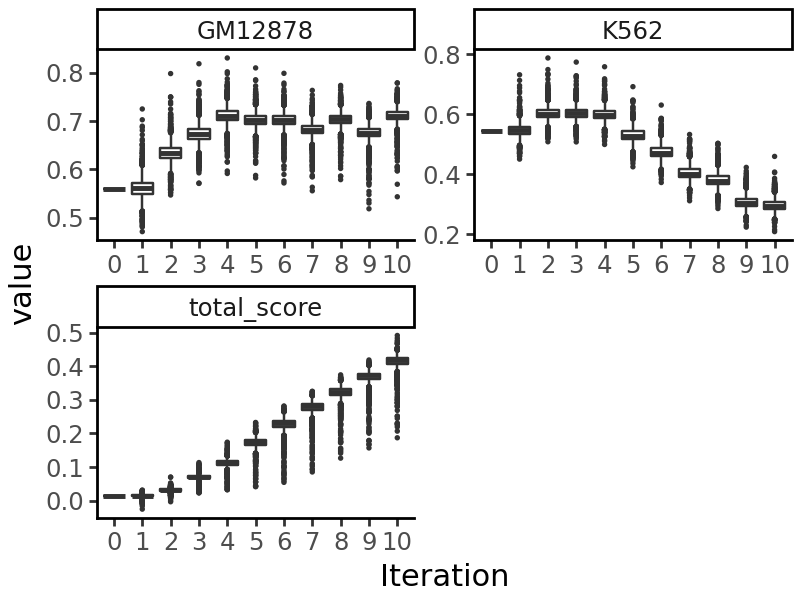

In [23]:
import grelu.visualize
grelu.visualize.plot_evolution(output, outlier_size=.1)